<a href="https://colab.research.google.com/github/PurvajaSawalakhe/Feedback-System/blob/main/practical_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)        │ (None, 32)             │       648,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 649,473 (2.48 MB)

 Trainable params: 649,473 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 344ms/step - accuracy: 0.5140 - loss: 0.7125 - val_accuracy: 1.0000 - val_loss: 0.1274
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.1167 - val_accuracy: 1.0000 - val_loss: 0.1171
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0926 - val_accuracy: 1.0000 - val_loss: 0.1147
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 0.0852 - val_accuracy: 1.0000 - val_loss: 0.1111
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0852 - val_accuracy: 1.0000 - val_loss: 0.0973
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0769 - val_accuracy: 1.0000 - val_loss: 0.0888
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0689 - val_accuracy: 1.0000 - val_loss: 0.0830
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0457 - val_accuracy: 1.0000 - val_loss: 0.077

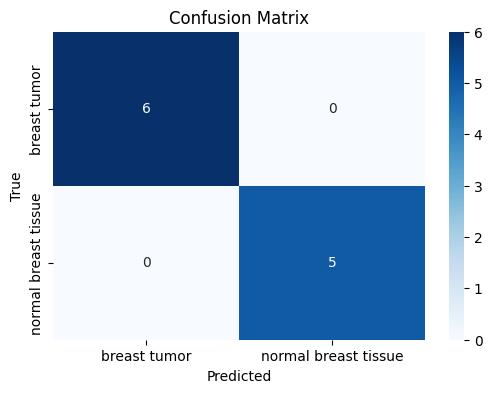

Model saved as breast_tissue_rnn_model.h5


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Load dataset
df = pd.read_csv("/content/process_data.csv")

# Pivot the dataset: samples as rows, genes as columns
X = df.pivot(index='Sample', columns='Gene', values='FPKM')
X = X.fillna(0)  # fill missing FPKM values with 0

# Target: tissue per sample
y = df.groupby('Sample')['tissue'].first()  # each sample has one tissue label

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)

# Reshape for RNN (samples, timesteps=1, features=number of genes)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Build RNN model
model = Sequential([
    SimpleRNN(32, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=32, verbose=1)

# Evaluate
y_pred_proba = model.predict(X_test).ravel()
y_pred = (y_pred_proba >= 0.5).astype(int)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Save model
model.save("breast_tissue_rnn_model.h5")
print("Model saved as breast_tissue_rnn_model.h5")
